In [1]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv(".env"))  # read local .env file

In [2]:
from pathlib import Path
from tqdm import tqdm

In [3]:
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.core import Settings

openai_api_version = "2023-07-01-preview"

gpt4 = AzureOpenAI(
    azure_deployment="gpt-4-1106",
    openai_api_version=openai_api_version,
)

# You need to deploy your own embedding model as well as your own chat completion model
embed_model = AzureOpenAIEmbedding(
    deployment_name="text-embedding-ada-002",
    api_version=openai_api_version,
    embed_batch_size=100,
)

Settings.llm = gpt4
Settings.embed_model = embed_model

## Set up the processor and the parser

In [ ]:
text_model = AzureOpenAI(
    azure_deployment="gpt-4-1106",
    openai_api_version="2023-07-01-preview",
)
vision_model = AzureOpenAIMultiModal(
    azure_deployment="gpt-4-v",
    openai_api_version="2023-07-01-preview",
    max_new_tokens=4096,
)

In [4]:
from pdf_processor.core import MathpixProcessor, MathpixResultParser
from pdf_processor.core import MathpixResult, PdfResult

In [ ]:
processor = MathpixProcessor()
parser = MathpixResultParser(text_model, vision_model)

## Load example PDF

In [5]:
pdf_path = Path("inbox/2312.10997.pdf")

In [6]:
result_path = Path("results").joinpath(pdf_path.stem)
result_path.mkdir(exist_ok=True, parents=True)

## Run PDF through Mathpix API

Skip the processing and load the result from a JSON

In [ ]:
mathpix_result = processor.submit_pdf(pdf_path)
mathpix_result = processor.await_result(mathpix_result, timeout_s=120)

In [ ]:
# with result_path.joinpath("mathpix_result.json").open("w") as f:
#     f.write(mathpix_result.model_dump_json())

# with result_path.joinpath("mathpix_result.json").open("r") as f:
#     mathpix_result = MathpixResult.model_validate_json(f.read())

## Parse Mathpix output through the parser

Same deal here, load from JSON

In [ ]:
pdf_result = parser.parse_result(mathpix_result)

In [ ]:
# Store results

# with result_path.joinpath("pdf_result-2.json").open("w") as f:
#     f.write(pdf_result.model_dump_json())

# Load results

# with result_path.joinpath("pdf_result-2.json").open("r") as f:
#     pdf_result = PdfResult.model_validate_json(f.read())

## Convert PdfResult into LlamaIndex nodes

In [9]:
from llama_index.core.schema import TextNode, ImageNode, IndexNode, NodeRelationship

In [10]:
stored_nodes = []
full_nodes_dict = {}

In [11]:
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Document

splitter = SentenceSplitter()
for text_chunk in pdf_result.text:
    doc = Document(text=text_chunk.processed_content)
    nodes = splitter.get_nodes_from_documents([doc])
    
    for node in nodes:
        node.start_char_idx += text_chunk.start
        node.end_char_idx += text_chunk.end
        
    stored_nodes.extend(nodes)

In [12]:
for table_chunk in pdf_result.tables:
    full_node = TextNode(
        text=table_chunk.raw_content,
        start_char_idx=table_chunk.start,
        end_char_idx=table_chunk.end,
    )
    stored_node = IndexNode.from_text_node(
        node=TextNode(
            text=table_chunk.processed_content,
            start_char_idx=table_chunk.start,
            end_char_idx=table_chunk.end,
        ),
        index_id=full_node.node_id,
    )
    stored_nodes.append(stored_node)
    full_nodes_dict[full_node.node_id] = full_node


In [13]:
for image_chunk in pdf_result.images:
    full_node = ImageNode(  # no text here
        image=image_chunk.file_b64,
        image_path=image_chunk.filename,
        image_mimetype="image/jpeg",
        start_char_idx=image_chunk.start,
        end_char_idx=image_chunk.end,
    )
    stored_node = IndexNode.from_text_node(
        node=TextNode(
            text=image_chunk.processed_content,
            start_char_idx=image_chunk.start,
            end_char_idx=image_chunk.end,
        ),
        index_id=full_node.node_id,
    )
    stored_nodes.append(stored_node)
    full_nodes_dict[full_node.node_id] = full_node

Set neighboring nodes relationships

In [14]:
stored_nodes = sorted(stored_nodes, key=lambda node: node.start_char_idx)

for i, node in enumerate(stored_nodes):
    if i > 0:
        node.relationships[NodeRelationship.PREVIOUS] = stored_nodes[i - 1].as_related_node_info()
    if i < len(stored_nodes) - 1:
        node.relationships[NodeRelationship.NEXT] = stored_nodes[i + 1].as_related_node_info()

## Set up LlamaIndex hierarchical retrieval

In [16]:
from llama_index.core import VectorStoreIndex

vector_index = VectorStoreIndex(stored_nodes)
vector_retriever = vector_index.as_retriever(similarity_top_k=5)

In [17]:
from llama_index.core.retrievers import RecursiveRetriever

recursive_retriever = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever},
    node_dict=full_nodes_dict,
    verbose=False,
)

In [19]:
retrieved_nodes = recursive_retriever.retrieve("What paradigms of RAG exist?")

Retrieving with query id None: What paradigms of RAG exist?
Retrieving text node: \end{center}

Modular RAG

Figure 3: Comparison between the three paradigms of RAG

is depicted in Figure 3. However, Modular RAG is not standalone. Advanced RAG is a specialized form of modular RAG, and further, Naive RAG itself is a special case of Advanced RAG. The relationship among the three paradigms is one of inheritance and development.

\section*{New Modules}
Search Module. In contrast to the similarity retrieval in Naive/Advanced RAG, the Search Module is tailored to specific scenarios and incorporates direct searches on additional corpora. This integration is achieved using code generated by the LLM, query languages such as SQL or Cypher, and other custom tools. The data sources for these searches can include search engines, text data, tabular data, and knowledge graphs [Wang et al., 2023d].

Memory Module. This module harnesses the memory capabilities of the LLM to guide retrieval. The approac

In [ ]:
for node in retrieved_nodes:
    print(type(node.node))

In [20]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import base64
from io import BytesIO


def plot_images(b64_images):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for encoded_image in b64_images:
        decoded_image = base64.b64decode(encoded_image)
        image = Image.open(BytesIO(decoded_image))

        plt.subplot(2, 3, images_shown + 1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

        images_shown += 1
        if images_shown >= 9:
            break

**Node ID:** b742a42a-6199-4d52-b7da-e13626612a76<br>**Similarity:** 0.8588535325558981<br>**Text:** \end{center}

Modular RAG

Figure 3: Comparison between the three paradigms of RAG

is depicted in Figure 3. However, Modular RAG is not standalone. Advanced RAG is a specialized form of modular RA...<br>

**Node ID:** 4870b988-1df2-471a-a692-c6d0e1afdb18<br>**Similarity:** 0.853568086931692<br>**Text:** During the evolution of the RAG technology landscape, there has been a clear divergence towards different specializations, such as: 1) Customization. Tailoring RAG to meet a specific requirements. ...<br>

**Node ID:** 1b883499-feec-409e-8a93-f93084137075<br>**Similarity:** 0.8439902079491434<br>**Text:** \end{center}

Figure 7: Summary of RAG ecosystem

\section*{9 Conclusion}
The summary of this paper, as depicted in Figure 7, highlights RAG's significant advancement in enhancing the capabilities ...<br>

**Node ID:** 2e82a632-36e0-42e0-bc01-27774a3c71d2<br>**Similarity:** 0.8417990083551489<br>**Text:** \begin{abstract}
Large Language Models (LLMs) demonstrate significant capabilities but face challenges such as hallucination, outdated knowledge, and nontransparent, untraceable reasoning processes...<br>

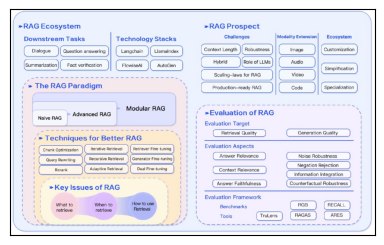

In [22]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for node in retrieved_nodes:
    if isinstance(node.node, ImageNode):
        retrieved_image.append(node.node.image)
    else:
        display_source_node(node, source_length=200)

plot_images(retrieved_image)